In [1]:
import dask
import json
import numpy
import xarray
import pyproj
import pandas
#import requests
import geopandas
from matplotlib import colors
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask.distributed import progress

import zarr
import fsspec
from pyproj import Transformer
from s3fs import S3FileSystem
from kerchunk.combine import MultiZarrToZarr

import rioxarray
from geocube.api.core import make_geocube


In [2]:
# use a try accept loop so we only instantiate the client
# if it doesn't already exist.
try:
    print(client.dashboard_link)
except:    
    # The client should be customized to your workstation resources.
    client = Client(n_workers=2, memory_limit='2GB') # per worker
    print(client.dashboard_link)

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51543 instead
  warnings.warn(


http://127.0.0.1:51543/status


Task exception was never retrieved
future: <Task finished name='Task-107341' coro=<Client._gather.<locals>.wait() done, defined at /Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


In [3]:
# define the selected watershed boundary 
wb_id = 'wb-2851655'

# define the year of interest
year=2010

Load Forcing Data

In [4]:
bucket = 's3://ciroh-nwm-zarr-retrospective-data-copy/noaa-nwm-retrospective-2-1-zarr-pds/forcing/'

# create an instace of the S3FileSystem class from s3fs
s3 = S3FileSystem(anon=True)
files = s3.ls(f'{bucket}{year}')  

new_files = []
for f in files:
    parts = f.split('/')
    parts[0] += '.s3.amazonaws.com'
    parts.insert(0, 'https:/')
    new_name = '/'.join(parts)
    new_files.append(new_name)


json_list = new_files[0:217] 

mzz = MultiZarrToZarr(json_list,
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['valid_time'])

d = mzz.translate()

backend_args = {"consolidated": False, "storage_options": {"fo": d}, "consolidated": False}

ds = xarray.open_dataset("reference://", engine="zarr", backend_kwargs=backend_args)

ds = ds.squeeze(dim='Time')

ds_meta = xarray.open_dataset('WRF_Hydro_NWM_geospatial_data_template_land_GIS.nc')
leny = len(ds_meta.y)
x = ds_meta.x.values
y = ds_meta.y.values

ds = ds.rename({'valid_time': 'time', 'south_north':'y', 'west_east':'x'})

X, Y = numpy.meshgrid(x, y)

# define the input crs
wrf_proj = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000)

# define the output crs
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# transform X, Y into Lat, Lon
transformer = pyproj.Transformer.from_crs(wrf_proj.crs, wgs_proj.crs)
lon, lat = transformer.transform(X, Y)

ds = ds.assign_coords(lon = (['y', 'x'], lon))
ds = ds.assign_coords(lat = (['y', 'x'], lat))
ds = ds.assign_coords(x = x)
ds = ds.assign_coords(y = y)

ds.x.attrs['axis'] = 'X'
ds.x.attrs['standard_name'] = 'projection_x_coordinate'
ds.x.attrs['long_name'] = 'x-coordinate in projected coordinate system'
ds.x.attrs['resolution'] = 1000.  # cell size

ds.y.attrs['axis'] = 'Y' 
ds.y.attrs['standard_name'] = 'projection_y_coordinate'
ds.y.attrs['long_name'] = 'y-coordinate in projected coordinate system'
ds.y.attrs['resolution'] = 1000.  # cell size

ds.lon.attrs['units'] = 'degrees_east'
ds.lon.attrs['standard_name'] = 'longitude' 
ds.lon.attrs['long_name'] = 'longitude'

ds.lat.attrs['units'] = 'degrees_north'
ds.lat.attrs['standard_name'] = 'latitude' 
ds.lat.attrs['long_name'] = 'latitude'

# add crs to netcdf file
ds.rio.write_crs(ds_meta.crs.attrs['spatial_ref'], inplace=True
                ).rio.set_spatial_dims(x_dim="x",
                                       y_dim="y",
                                       inplace=True,
                                       ).rio.write_coordinate_system(inplace=True);


In [5]:
# prepare geometries for spatial averaging
gdf = geopandas.read_file(f'domain/v20.1/{wb_id}/{wb_id.split("_")[0]}_upstream_subset.gpkg', layer='divides')


# convert these data into the projection of our forcing data
target_crs = pyproj.Proj(proj='lcc',
                       lat_1=30.,
                       lat_2=60., 
                       lat_0=40.0000076293945, lon_0=-97., # Center point
                       a=6370000, b=6370000) 

gdf = gdf.to_crs(target_crs.crs)

# important step
# rechunk the dataset to solve the memory limit issue
ds = ds.chunk(chunks={'time': 1})

Add Cell Number to Dataset

In [6]:
wgrid = json.load(open('forcing_grids.json', 'r'))

xs = ds.x.values
ys = ds.y.values
dx = ds.x.resolution
dy = ds.y.resolution

xmin = ds.x.min().item() - dx / 2 
xmax = ds.x.max().item() + dx / 2
ymin = ds.y.min().item() - dy / 2
ymax = ds.y.max().item() + dy / 2
ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]

print(f'xmin == grid-X1 : {xmin == wgrid[0]["X1"]}')
print(f'xmax == grid-Xn : {xmax == wgrid[0]["Xn"]}')
print(f'ymin == grid-Y1 : {ymin == wgrid[0]["Y1"]}')
print(f'ymax == grid-Yn : {ymax == wgrid[0]["Yn"]}')
print(f'nrows == grid-nrows : {ds_nrows == wgrid[0]["nrows"]}')
print(f'ncols == grid-ncols : {ds_ncols == wgrid[0]["ncols"]}')



# # unravel x, y coordinates into point pairs
rr, cc = numpy.meshgrid(ys, xs)
pair_pts = numpy.array([rr, cc]).T.reshape(-1, 2)

yss = pair_pts[:,0]
xss = pair_pts[:,1]

# compute cell number
cell_number = numpy.round( ((ymax - (yss + dy / 2)) / dy ) * ds_ncols) + \
              numpy.round((xss - (xmin - dx / 2)) / dx) 


cell_ids = cell_number.reshape(ds_nrows, ds_ncols)

# add as a new variable to the dataset
ds['cell_number']=(['y','x'], cell_ids)

xmin == grid-X1 : True
xmax == grid-Xn : True
ymin == grid-Y1 : True
ymax == grid-Yn : True
nrows == grid-nrows : True
ncols == grid-ncols : True


In [8]:
cell_number[1000]

1001.0

Sanity check

In [231]:
# cat_id = 2851705

# # isolate a single catchment that we're interested in
# # Select the cells that intersect with this boundary.
# ds_catchment = ds.rio.clip(gdf.loc[gdf.divide_id == f'cat-{cat_id}'].geometry.values,
#                  gdf.crs,
#                  drop=True,
#                  invert=False,
#                  from_disk=True,
#                  all_touched=True
#                 )

# computed_cells = ds_catchment.cell_number.values.flatten()
# computed_cells = computed_cells[~numpy.isnan(computed_cells)]
# computed_cells.sort()


# # for w in computed_weights:
# #     print(w)

# valid_cells = [7452275.0,
# 7452276.0,
# 7452277.0,
# 7456883.0,
# 7456884.0,
# 7456885.0,
# 7456886.0,
# 7461491.0,
# 7461492.0,
# 7461493.0,
# 7461494.0,
# 7466101.0,
# 7466102.0]

# for i in range(0, len(computed_cells)):
#     print(computed_cells[i] - valid_cells[i])
    

Add some random values to the dataset for prettier mapping

In [9]:
randx = numpy.random.rand(len(xs),1)
randy = numpy.random.rand(len(ys),1)

In [10]:
ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]

# unravel x, y coordinates into point pairs
rr, cc = numpy.meshgrid(randy, randx)
pair_pts = numpy.array([rr, cc]).T.reshape(-1, 2)

yss = pair_pts[:,0]
xss = pair_pts[:,1]

# # compute random number
rand_vals = xss + yss 
rand_reshape = rand_vals.reshape(ds_nrows, ds_ncols)

# add as a new variable to the dataset
ds['rand']=(['y','x'], rand_reshape)

### Extract Weights for Region of Interest

Get geometry from HydroFabric for area of interest

In [11]:
cat_id = 2851705

In [12]:
# isolate a single catchment that we're interested in
# Select the cells that intersect with this boundary.
ds_catchment = ds.rio.clip(gdf.loc[gdf.divide_id == f'cat-{cat_id}'].geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False,
                 from_disk=True,
                 all_touched=True
                )

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 270.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(-1166453.7103159062, -1161568.241439442)

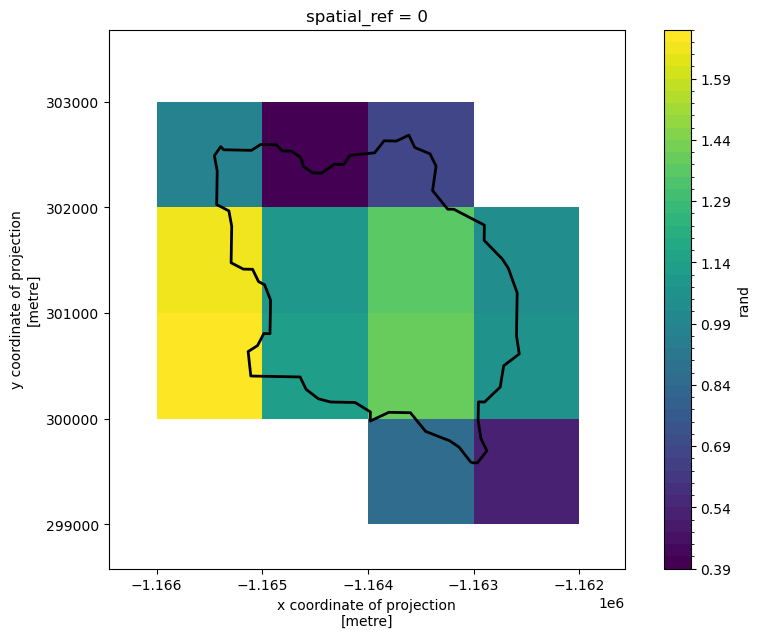

In [13]:
figure, ax = plt.subplots(figsize=(10,7))

ds_catchment.rand.plot(levels=50)

# preview map geometries
current_geom = gdf.loc[gdf.divide_id == f'cat-{cat_id}']
gdf.loc[gdf.divide_id == f'cat-{cat_id}'].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

xmin = current_geom.geometry.bounds.minx.item()
xmax = current_geom.geometry.bounds.maxx.item()
ymin = current_geom.geometry.bounds.miny.item()
ymax = current_geom.geometry.bounds.maxy.item()

ax.set_ylim((ymin - 1000, ymax + 1000))
ax.set_xlim((xmin - 1000, xmax + 1000))

Print the cell numbers that are stored in the weights file

In [14]:
# read the pre-computed weights 
weights = pandas.read_parquet('s3://lynker-spatial/v20.1/forcing_weights.parquet')

In [238]:
weights.loc[weights.divide_id == f'cat-{cat_id}'].sort_values(by='cell')

,divide_id,cell,coverage_fraction,grid_id
13796086,cat-2851705,7452275.0,0.239241,medium_range.forcing.conus
13796087,cat-2851705,7452276.0,0.464558,medium_range.forcing.conus
13796088,cat-2851705,7452277.0,0.374510,medium_range.forcing.conus
13796089,cat-2851705,7456883.0,0.178932,medium_range.forcing.conus
13796090,cat-2851705,7456884.0,0.983314,medium_range.forcing.conus
13796091,cat-2851705,7456885.0,0.986789,medium_range.forcing.conus
13796092,cat-2851705,7456886.0,0.240772,medium_range.forcing.conus
13796093,cat-2851705,7461491.0,0.035560,medium_range.forcing.conus
13796094,cat-2851705,7461492.0,0.725238,medium_range.forcing.conus
13796095,cat-2851705,7461493.0,0.980662,medium_range.forcing.conus


In [15]:
weight_cells = weights.loc[weights.divide_id == f'cat-{cat_id}'].cell.values

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 270.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


(-1166453.7103159062, -1161568.241439442)

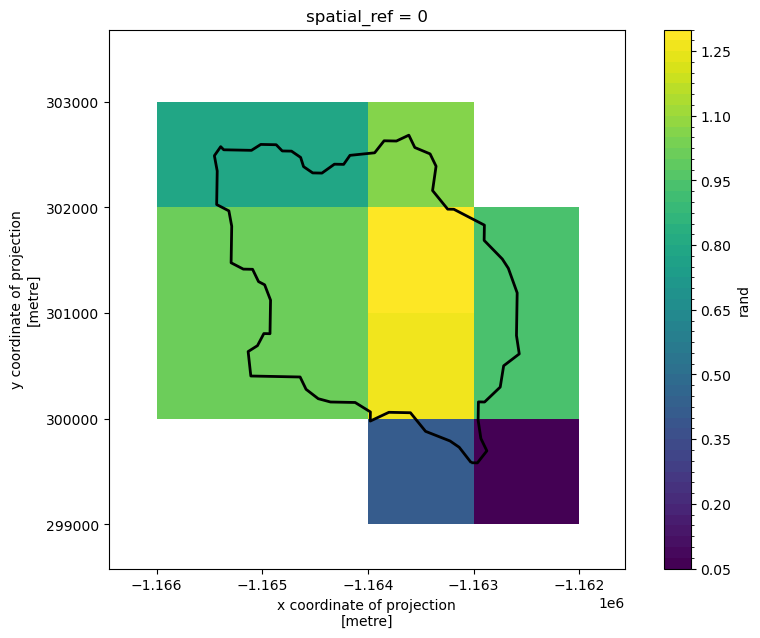

In [240]:
# plot the weights grid cells along with the geometry

figure, ax = plt.subplots(figsize=(10,7))

ds_catchment.where(ds_catchment.cell_number.isin(weight_cells), drop=True).rand.plot(levels=50)

# preview map geometries
current_geom = gdf.loc[gdf.divide_id == f'cat-{cat_id}']
gdf.loc[gdf.divide_id == f'cat-{cat_id}'].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

xmin = current_geom.geometry.bounds.minx.item()
xmax = current_geom.geometry.bounds.maxx.item()
ymin = current_geom.geometry.bounds.miny.item()
ymax = current_geom.geometry.bounds.maxy.item()

ax.set_ylim((ymin - 1000, ymax + 1000))
ax.set_xlim((xmin - 1000, xmax + 1000))

Naive computation using weights

In [17]:
weights = weights.loc[weights.divide_id == f'cat-{cat_id}']

In [18]:
pcp_total = 0
for idx, row in weights.iterrows():
    print(f'{idx}  {row.cell}  {row.coverage_fraction}')
    #pcp_total += ds_catchment.where(ds_catchment.cell_number == row.cell).iloc[time=0].RAINRATE.item() * row.coverage_fraction

13796086  7452275.0  0.23924146592617035
13796087  7452276.0  0.46455761790275574
13796088  7452277.0  0.3745102882385254
13796089  7456883.0  0.17893154919147491
13796090  7456884.0  0.9833137392997742
13796091  7456885.0  0.9867888689041138
13796092  7456886.0  0.24077242612838745
13796093  7461491.0  0.03556038811802864
13796094  7461492.0  0.7252376079559326
13796095  7461493.0  0.9806622266769409
13796096  7461494.0  0.2843189537525177
13796097  7466101.0  0.11339616030454636
13796098  7466102.0  0.030284423381090164


In [19]:
ds_catchment.isel(time=0).where(ds_catchment.cell_number == 7452275.0, drop=True).RAINRATE.values()

/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-27 16:26:51,800 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('where-getitem-a625df98ca28722d009d371dad7ae05f', 0, 0))" coro=<Worker.execute() done, defined at /Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError


KeyboardInterrupt: 

2024-03-27 16:26:53,827 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/base_events.py", line 685, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/nanny.py", line 983, in run
    await worker.finished()
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/core.py", line 630, in finished
    await self._event_finished.wait()
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/locks.py", line 212, i

In [11]:
ds_catchment = ds.rio.clip(gdf.loc[gdf.divide_id == f'cat-{cat_id}'].geometry.values,
                 gdf.crs,
                 drop=True,
                 invert=False,
                 from_disk=True,
                 all_touched=True
                )

In [20]:
ds_catchment

<xarray.Dataset> Size: 118kB
Dimensions:      (time: 217, y: 4, x: 4)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
    lat          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
  * x            (x) float64 32B -1.165e+06 -1.164e+06 -1.163e+06 -1.162e+06
  * y            (y) float64 32B 3.025e+05 3.015e+05 3.005e+05 2.995e+05
    spatial_ref  int64 8B 0
Data variables:
    LWDOWN       (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    PSFC         (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    Q2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    RAINRATE     (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    SWDOWN       (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    T2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    Times        (time) |S20 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    U2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    V2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    cell_number  (y, x) float64 128B 7.452e+06 7.452e+06 ... 7.466e+06 7.466e+06
    rand         (y, x) float64 128B 0.9667 0.3993 0.6738 ... nan 0.8595 0.5277

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/base_events.py", line 685, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/nanny.py", line 983, in run
    await worker.finished()
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/site-packages/distributed/core.py", line 630, in finished
    await self._event_finished.wait()
  File "/Users/castro/Documents/work/notebooks/ngen/conda-env/lib/python3.12/asyncio/locks.py", line 212, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the above ex

In [13]:
wgrid = json.load(open('forcing_grids.json', 'r'))

xs = ds_catchment.x.values
ys = ds_catchment.y.values
output_nrows, output_ncols = ds_catchment.LWDOWN.shape[1:]

dx = ds.x.resolution
dy = ds.y.resolution
xmin = ds.x.min().item() - dx / 2 
xmax = ds.x.max().item() + dx / 2 
ymin = ds.y.min().item() - dy / 2 
ymax = ds.y.max().item() + dy / 2 
ds_nrows, ds_ncols = ds.LWDOWN.shape[1:]

# unravel x, y coordinates into point pairs
rr, cc = numpy.meshgrid(xs, ys)
pair_pts = numpy.array([rr, cc]).T.reshape(-1, 2)

xss = pair_pts[:,0]
yss = pair_pts[:,1]

# compute cell number
cell_number = ((ymax - (yss - dy/2)) / dy * ds_ncols + ((xss- dy/2) - xmin) / dx).round()

cell_ids = cell_number.reshape(output_nrows, output_ncols)

# add as a new variable to the dataset
ds_catchment['cell_number']=(['y','x'], cell_ids)

In [14]:
ds_catchment

<xarray.Dataset> Size: 118kB
Dimensions:      (time: 217, y: 4, x: 4)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2010-01-01 ... 2010-01-10
    lon          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
    lat          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
  * x            (x) float64 32B -1.165e+06 -1.164e+06 -1.163e+06 -1.162e+06
  * y            (y) float64 32B 3.025e+05 3.015e+05 3.005e+05 2.995e+05
    spatial_ref  int64 8B 0
Data variables:
    LWDOWN       (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    PSFC         (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    Q2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    RAINRATE     (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    SWDOWN       (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    T2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    Times        (time) |S20 4kB dask.array<chunksize=(1,), meta=np.ndarray>
    U2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    V2D          (time, y, x) float32 14kB dask.array<chunksize=(1, 4, 4), meta=np.ndarray>
    cell_number  (y, x) float64 128B 7.457e+06 7.461e+06 ... 7.466e+06 7.471e+06

In [15]:
ds_catchment.cell_number

<xarray.DataArray 'cell_number' (y: 4, x: 4)> Size: 128B
array([[7456882., 7461490., 7466098., 7470706.],
       [7456883., 7461491., 7466099., 7470707.],
       [7456884., 7461492., 7466100., 7470708.],
       [7456885., 7461493., 7466101., 7470709.]])
Coordinates:
    lon          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
    lat          (y, x) float64 128B dask.array<chunksize=(4, 4), meta=np.ndarray>
  * x            (x) float64 32B -1.165e+06 -1.164e+06 -1.163e+06 -1.162e+06
  * y            (y) float64 32B 3.025e+05 3.015e+05 3.005e+05 2.995e+05
    spatial_ref  int64 8B 0

In [73]:
catchment_weights = weights.loc[weights.divide_id == f'cat-{cat_id}'].sort_values(by='cell')
catchment_weights

,divide_id,cell,coverage_fraction,grid_id
13796086,cat-2851705,7452275.0,0.239241,medium_range.forcing.conus
13796087,cat-2851705,7452276.0,0.464558,medium_range.forcing.conus
13796088,cat-2851705,7452277.0,0.374510,medium_range.forcing.conus
13796089,cat-2851705,7456883.0,0.178932,medium_range.forcing.conus
13796090,cat-2851705,7456884.0,0.983314,medium_range.forcing.conus
13796091,cat-2851705,7456885.0,0.986789,medium_range.forcing.conus
13796092,cat-2851705,7456886.0,0.240772,medium_range.forcing.conus
13796093,cat-2851705,7461491.0,0.035560,medium_range.forcing.conus
13796094,cat-2851705,7461492.0,0.725238,medium_range.forcing.conus
13796095,cat-2851705,7461493.0,0.980662,medium_range.forcing.conus


In [74]:
ids = numpy.unique(ds_catchment.cell_number)
ids.sort()
for cell in ids:
    print(f'{cell} in weights -> {cell in catchment_weights.cell.values}')

7456882.0 in weights -> False
7456883.0 in weights -> True
7456884.0 in weights -> True
7456885.0 in weights -> True
7461490.0 in weights -> False
7461491.0 in weights -> True
7461492.0 in weights -> True
7461493.0 in weights -> True
7466098.0 in weights -> False
7466099.0 in weights -> False
7466100.0 in weights -> False
7466101.0 in weights -> True
7470706.0 in weights -> False
7470707.0 in weights -> False
7470708.0 in weights -> False
7470709.0 in weights -> False


In [71]:
ds_catchment.where(ds_catchment.cell_number.isin(catchment_weights.cell.values), drop=True).cell_number

<xarray.DataArray 'cell_number' (y: 3, x: 3)> Size: 72B
array([[7456883., 7461491.,      nan],
       [7456884., 7461492.,      nan],
       [7456885., 7461493., 7466101.]])
Coordinates:
    lon          (y, x) float64 72B dask.array<chunksize=(3, 3), meta=np.ndarray>
    lat          (y, x) float64 72B dask.array<chunksize=(3, 3), meta=np.ndarray>
  * x            (x) float64 24B -1.165e+06 -1.164e+06 -1.163e+06
  * y            (y) float64 24B 3.015e+05 3.005e+05 2.995e+05
    spatial_ref  int64 8B 0

NameError: name 'catchment_weights' is not defined

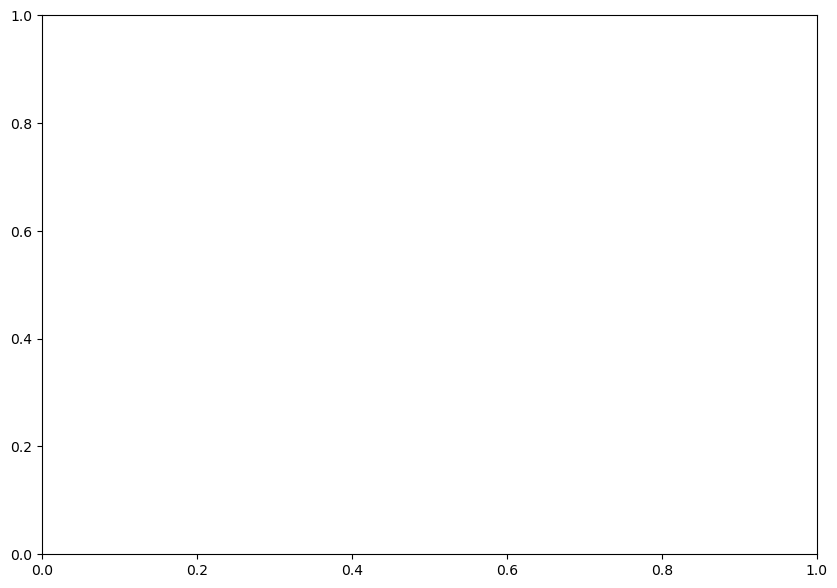

In [16]:
# plot the weights grid cells along with the geometry

figure, ax = plt.subplots(figsize=(10,7))

ds_catchment.where(ds_catchment.cell_number.isin(catchment_weights.cell.values), drop=True).cell_number.plot(levels=50)

# preview map geometries
current_geom = gdf.loc[gdf.divide_id == f'cat-{cat_id}']
gdf.loc[gdf.divide_id == f'cat-{cat_id}'].plot(ax=ax, linewidth=2, edgecolor='k', facecolor='None');

xmin = current_geom.geometry.bounds.minx.item()
xmax = current_geom.geometry.bounds.maxx.item()
ymin = current_geom.geometry.bounds.miny.item()
ymax = current_geom.geometry.bounds.maxy.item()

ax.set_ylim((ymin, ymax))
ax.set_xlim((xmin, xmax))